In [ ]:
from gerrychain import Graph

In [ ]:
!pip install gerrychain

In [ ]:
from gerrychain import Graph

filepath = '/content/'
filename = 'Arkansas_county.json'

file_path = filepath + filename
G = Graph.from_json(file_path)


In [ ]:
for node, node_data in G.nodes(data=True):
    node_data['TOTPOP'] = node_data['P0010001']

In [ ]:
import math
deviation = 0.01
num_partitions = 4

total_population = sum(G.nodes[node]['TOTPOP'] for node in G.nodes)

lower_bound = math.ceil((1 - deviation / 2) * total_population / num_partitions)
upper_bound = math.floor((1 + deviation / 2) * total_population / num_partitions)

print(f"Using Lower Bound = {lower_bound}, Upper Bound = {upper_bound}, and k = {num_partitions}")


Using Lower Bound = 749117, Upper Bound = 756645, and k = 4


In [ ]:
# Install Gurobi
!apt-get install -y -qq software-properties-common
!add-apt-repository -y ppa:deadsnakes/ppa
!apt-get update -y -qq
!apt-get install -y -qq gurobi gurobi9 libgurobi9

# Install Gurobi Python Interface
!python3 -m pip install gurobipy

Repository: 'deb https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu/ jammy main'
Description:
This PPA contains more recent Python versions packaged for Ubuntu.

Disclaimer: there's no guarantee of timely updates in case of security problems or other issues. If you want to use them in a security-or-otherwise-critical environment (say, on a production server), you do so at your own risk.

Update Note
Please use this repository instead of ppa:fkrull/deadsnakes.

Reporting Issues

Issues can be reported in the master issue tracker at:
https://github.com/deadsnakes/issues/issues

Supported Ubuntu and Python Versions

- Ubuntu 20.04 (focal) Python3.5 - Python3.7, Python3.9 - Python3.13
- Ubuntu 22.04 (jammy) Python3.7 - Python3.9, Python3.11 - Python3.13
- Note: Python2.7 (all), Python 3.8 (focal), Python 3.10 (jammy) are not provided by deadsnakes as upstream ubuntu provides those packages.

Why some packages aren't built:
- Note: for focal, older python versions require libssl<1.1 so 

In [ ]:
import gurobipy as gp
from gurobipy import GRB

# Create model
model = gp.Model()

# Create variables
x = model.addVars(G.nodes, num_partitions, vtype=GRB.BINARY)  # x[i, j] equals one when county i is assigned to district j
y = model.addVars(G.edges, vtype=GRB.BINARY)     # y[u, v] equals one when edge {u, v} is cut


In [ ]:
model.setObjective(gp.quicksum(G.edges[u, v]['shared_perim'] * y[u, v] for u, v in G.edges), GRB.MINIMIZE)


In [ ]:
# Constraints ensuring that each county is assigned to precisely one district
model.addConstrs(gp.quicksum(x[i, j] for j in range(num_partitions)) == 1 for i in G.nodes)

# Constraints ensuring that each district has population of at least L and at most U
model.addConstrs(gp.quicksum(G.nodes[i]['TOTPOP'] * x[i, j] for i in G.nodes) >= lower_bound  for j in range(num_partitions))
model.addConstrs(gp.quicksum(G.nodes[i]['TOTPOP'] * x[i, j] for i in G.nodes) <= upper_bound for j in range(num_partitions))

# Constraints indicating that an edge {u, v} is cut if u is assigned to district j but v is not
model.addConstrs(x[u, j] - x[v, j] <= y[u, v] for u, v in G.edges for j in range(num_partitions))

model.update()


In [ ]:
# Add root variables: r[i, j] equals 1 if node i is the "root" of district j
root_vars = model.addVars(G.nodes, num_partitions, vtype=GRB.BINARY)

# Fix certain district roots to solve the MIP faster:
root_vars[20, 0].LB = 1  # fix Oklahoma county as root of district 0
root_vars[37, 1].LB = 1  # fix Tulsa county as root of district 1
root_vars[62, 2].LB = 1  # fix Comanche county as root of district 2
root_vars[56, 3].LB = 1

# Add flow variables: f[u, v] = amount of flow sent across arc uv
# Flows are routed over arcs of the directed form of G, denoted as DG

import networkx as nx
DG = nx.DiGraph(G)  # directed version of G

flow_vars = model.addVars(DG.edges)


In [ ]:
# The big-M suggested by Hojny et al.
M = G.number_of_nodes() - num_partitions + 1

# Every district needs to have only one root
model.addConstrs(gp.quicksum(root_vars[i, j] for i in G.nodes) == 1 for j in range(num_partitions))

# Node i cannot be the root of district j if it isn't assigned to it
model.addConstrs(root_vars[i, j] <= x[i, j] for i in G.nodes for j in range(num_partitions))

# Consume some flow if there isn't a root
# Send out (so much) flow only if there is a root
model.addConstrs(gp.quicksum(flow_vars[j, i] - flow_vars[i, j] for j in G.neighbors(i)) >= 1 - M * gp.quicksum(root_vars[i, j] for j in range(num_partitions)) for i in G.nodes)

# Flow should not be sent over cut edges
model.addConstrs(flow_vars[i, j] + flow_vars[j, i] <= M * (1 - y[i, j]) for i, j in G.edges)

model.update()


In [ ]:
model.optimize()

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 1422 rows, 1176 columns and 5748 nonzeros
Model fingerprint: 0xf1f792f7
Variable types: 384 continuous, 792 integer (792 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+05]
  Objective range  [2e-03, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+05]
Presolve removed 389 rows and 338 columns
Presolve time: 0.02s
Presolved: 1033 rows, 838 columns, 4255 nonzeros
Variable types: 382 continuous, 456 integer (456 binary)

Root relaxation: objective 6.025434e+00, 1079 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    6.02543    0  291          

In [ ]:
print("The number of cut edges is", model.objval)

districts = [[i for i in G.nodes if x[i, j].x > 0.5] for j in range(num_partitions)]
district_counties = [[G.nodes[i]["NAME20"] for i in districts[j]] for j in range(num_partitions)]
district_populations = [sum(G.nodes[i]["TOTPOP"] for i in districts[j]) for j in range(num_partitions)]

for j in range(num_partitions):
    print("District", j, "has population", district_populations[j], "and contains counties", district_counties[j])
    print("")


The number of cut edges is 12.00964554654077
District 0 has population 750788 and contains counties ['Faulkner', 'Conway', 'Pulaski', 'Saline', 'Lonoke', 'Perry']

District 1 has population 751754 and contains counties ['Franklin', 'Crawford', 'Benton', 'Madison', 'Sebastian', 'Washington']

District 2 has population 754435 and contains counties ['Jackson', 'Clay', 'Baxter', 'Boone', 'St. Francis', 'Sharp', 'Greene', 'Woodruff', 'White', 'Lee', 'Crittenden', 'Marion', 'Prairie', 'Lawrence', 'Poinsett', 'Stone', 'Independence', 'Fulton', 'Carroll', 'Van Buren', 'Searcy', 'Randolph', 'Izard', 'Craighead', 'Cleburne', 'Monroe', 'Mississippi', 'Newton', 'Cross']

District 3 has population 754547 and contains counties ['Little River', 'Ashley', 'Desha', 'Montgomery', 'Howard', 'Nevada', 'Grant', 'Dallas', 'Cleveland', 'Lafayette', 'Chicot', 'Pope', 'Bradley', 'Drew', 'Pike', 'Union', 'Hempstead', 'Polk', 'Clark', 'Logan', 'Miller', 'Arkansas', 'Johnson', 'Garland', 'Sevier', 'Jefferson', 'L

In [ ]:
import geopandas as gpd

filepath = '/content/'
filename = 'Arkansas_county.shp'
df = gpd.read_file( filepath + filename)

In [ ]:
!pip install geopandas

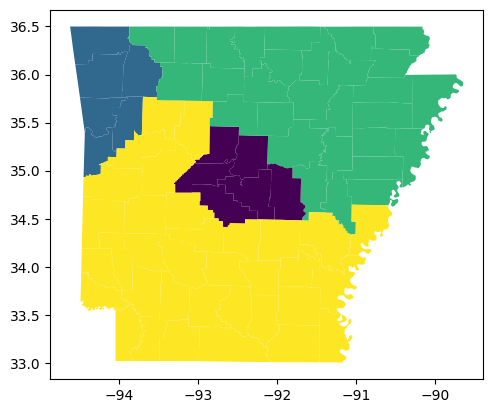

In [ ]:
Func_assign = [ -1 for i in G.nodes ]

labeling = { i : j for i in G.nodes for j in range(num_partitions) if x[i,j].x > 0.5 }

node_with_this_geoid = { G.nodes[i]['GEOID20'] : i for i in G.nodes }

for u in range(G.number_of_nodes()):

    geoid = df['GEOID20'][u]
    i = node_with_this_geoid[geoid]
    Func_assign[u] = labeling[i]

df['Func_assign'] = assignment
my_fig = df.plot(column='Func_assign').get_figure()